In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstat
from mpmath import mp
import math
import random
from scipy.stats import multivariate_normal

psd = pd.DataFrame
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

Generiamo 1000 sample da una normale:

\begin{equation*}
\begin{aligned}
    y_{obs} &\sim \mathcal{N}(\mu_{obs}, σ_{obs} ^2) \\
\end{aligned}
\end{equation*}

e scegliamo come modello:

\begin{equation*}
\begin{aligned}
    y_i | \mu &\sim ^{iid} \mathcal{N}(\mu, \sigma_{obs} ^2)  \\
    \mu & \sim \mathcal{N}(\mu_0, \sigma_0^2)
\end{aligned}
\end{equation*}

$\sigma_{obs}$ noto

$\mu_0, \sigma_0$ fissati

$\mathscr{L}(y_i|\mu)$:

In [2]:
def single_lik(mu,sigma):
   return tfd.Normal(mu,sigma)

# $\pi(\mu)$:

In [3]:
def prior_mu():
    return tfd.Normal(mu0,sigma0)

In [28]:
def prior_sigma2():
    return tfd.InverseGamma(c,d)

proposal distribution $g(\theta'|\theta)$= $N(\theta, 1)$

In [5]:
def proposal_mu(mu):
  return tfd.Normal(mu,1)

In [60]:
def proposal_sigma(sigma):
  return tfd.LogNormal(sigma,0.1)

definiamo la funzione Kernel Gaussiana

In [7]:
def my_kernel(u):
  return 1/(np.sqrt(2*math.pi))*np.exp(-1/2*u**2)

In [8]:
def K_h(u,h):
  return my_kernel(u/h)/h

Come summary statistics utilizziamo:


*   Quantili
*   Media campionaria



In [9]:
def S2(y):
  quantiles=[]
  for i in range(9):
      quantiles.append(np.quantile(y,0.1+0.1*i))         #quantili 0,1 0,2 0,3 0,4 0,5 0,6 0,7 0,8 0,9
  return quantiles

In [10]:
def S1(y):
  s_1 = np.mean(y)
  s_2 = np.var(y)
  return [s_1,s_2]

In [11]:
##MAXIMAL COUPLING FOR DATASET GENERATION
def maximal_coupling2(mu_x,sigma_x,mu_y,sigma_y):

      proposed_x = single_lik(mu_x,sigma_x).sample()
      pX =  single_lik(mu_x,sigma_x).prob(proposed_x)
      w = tfd.Uniform(0,1).sample()*pX
      qX = single_lik(mu_y,sigma_y).prob(proposed_x)
      if w < qX:
          x_new = proposed_x
          y_new = proposed_x
      else:
          t = True
          while t == True:
                proposed_y = single_lik(mu_y,sigma_y).sample()
                qY =  single_lik(mu_y,sigma_y).prob(proposed_y) 
                w =  tfd.Uniform(0,1).sample()*qY
                pY = single_lik(mu_x,sigma_x).prob(proposed_y)
                if w > pY :
                  t = False

          x_new = proposed_x
          y_new = proposed_y  
          
      return x_new,y_new

In [70]:
##MAXIMAL COUPLING OF MU
def maximal_coupling_mu(x,y):

      current_x = x
      current_y = y  
      proposed_x = current_x + tfd.Normal(0,0.1).sample()
      pX = sstat.norm.pdf(proposed_x,current_x,1)
      w = tfd.Uniform(0,1).sample()*pX
      qX = sstat.norm.pdf(proposed_x,current_y,1)
      if w < qX:
          x_new = proposed_x
          y_new = proposed_x
      else:
          t = True
          while t == True:
                proposed_y = current_y + tfd.Normal(0,1).sample()
                qY =  sstat.norm.pdf(proposed_y,current_y,1) 
                w =  tfd.Uniform(0,1).sample()*qY
                pY = sstat.norm.pdf(proposed_y,current_x,1)
                if w > pY :
                  t = False

          x_new = proposed_x
          y_new = proposed_y

      return x_new, y_new

In [19]:
##MAXIMAL COUPLING OF TAU
def maximal_coupling_sigma(x,y):
      
      current_x = x
      current_y = y  
      proposed_x = proposal_sigma(current_x).sample()
      pX = proposal_sigma(current_x).prob(proposed_x)
      w = tfd.Uniform(0,1).sample()*pX
      qX = proposal_sigma(current_y).prob(proposed_x)
      if w < qX:
          x_new = proposed_x
          y_new = proposed_x
      else:
          t = True
          while t == True:
                proposed_y = proposal_sigma(current_x).sample()
                qY =  proposal_sigma(current_y).prob(proposed_y) 
                w =  tfd.Uniform(0,1).sample()*qY
                pY = proposal_sigma(current_x).prob(proposed_y)
                if w > pY :
                  t = False

          x_new = proposed_x
          y_new = proposed_y  

      return x_new, y_new

ABC algorithm:

In [69]:
def abc_algo (N, S, y_obs, h):
    acc_x = 0
    acc_y = 0
    s_obs = S(y_obs)
    theta_mu_x = []
    theta_sigma_x = []
    theta_mu_y = []
    theta_sigma_y = []
    datax_current = []
    datay_current = [] 
    theta_sigma_x0 = np.sqrt(prior_sigma2().sample())
    theta_sigma_y0 = np.sqrt(prior_sigma2().sample())
    theta_mu_x0 = prior_mu().sample()
    theta_mu_y0 = prior_mu().sample()

    for j in range (100):
                  newdata_x,newdata_y = maximal_coupling2(theta_mu_x0,theta_sigma_x0,theta_mu_y0,theta_sigma_y0)
                  datax_current.append(newdata_x)
                  datay_current.append(newdata_y)
    sx_0 = S(datax_current)
    sy_0 = S(datay_current)

    while K_h(np.linalg.norm(np.array(sx_0)-np.array(s_obs)),h)<=0:
        theta_sigma_x0 = np.sqrt(prior_sigma2().sample())
        theta_mu_x0 = prior_mu().sample()
        datax_0 = single_lik(theta_mu_x0,theta_sigma_x0).sample(100) 
        sx_0 = S(datax_0)


    while K_h(np.linalg.norm(np.array(sy_0)-np.array(s_obs)),h)<=0:
        theta_sigma_y0 =np.sqrt(prior_sigma2().sample())
        theta_mu_y0 = prior_mu().sample()
        datay_0 = single_lik(theta_mu_y0,theta_sigma_y0).sample(100) 
        sy_0 = S(datay_0)
      
    theta_mu_x.append(theta_mu_x0)
    theta_sigma_x.append(theta_sigma_x0)
    theta_mu_y.append(theta_mu_y0)
    theta_sigma_y.append(theta_sigma_y0)
   
    theta_muold_x = theta_mu_x0
    theta_sigmaold_x = theta_sigma_x0
    theta_muold_y = theta_mu_y0
    theta_sigmaold_y = theta_sigma_y0
    sx_old = sx_0
    sy_old = sy_0
    

    for i in range(N):
        theta_mucurrent_x,theta_mucurrent_y = maximal_coupling_mu(theta_muold_x,theta_muold_y)
        theta_sigmacurrent_x,theta_sigmacurrent_y = maximal_coupling_sigma(theta_sigmaold_x,theta_sigmaold_y)

        datax_current = []
        datay_current = [] 

        for j in range (100):
                  [newdata_x,newdata_y] = maximal_coupling2(theta_mucurrent_x,theta_sigmacurrent_x,theta_mucurrent_y,theta_sigmacurrent_y)
                  datax_current.append(newdata_x)
                  datay_current.append(newdata_y)

        sx_current = S(datax_current)
        sy_current = S(datay_current) 
               
        xprob = min([1.,(K_h(np.linalg.norm(np.array(sx_current) - np.array(s_obs)),h)*prior_sigma2().prob(theta_sigmacurrent_x**2)*prior_mu().prob(theta_mucurrent_x))/(
             K_h(np.linalg.norm(np.array(sx_old)-np.array(s_obs)),h)*(prior_sigma2().prob(theta_sigmaold_x**2)*prior_mu().prob(theta_muold_x)))])
        yprob = min([1.,(K_h(np.linalg.norm(np.array(sy_current) - np.array(s_obs)),h)*prior_sigma2().prob(theta_sigmacurrent_y**2)*prior_mu().prob(theta_mucurrent_y))/(
             K_h(np.linalg.norm(np.array(sy_old)-np.array(s_obs)),h)*(prior_sigma2().prob(theta_sigmaold_y**2)*prior_mu().prob(theta_muold_y)))])
        # xprob = min([1.,(K_h(np.linalg.norm(np.array(sx_current) - np.array(s_obs)),h)*prior_sigma2().prob(theta_sigmacurrent_x**2)*prior_mu().prob(theta_mucurrent_x)*proposal_sigma(theta_sigmaold_x).prob(theta_sigmacurrent_x))/(
        #     K_h(np.linalg.norm(np.array(sx_old)-np.array(s_obs)),h)*(prior_sigma2().prob(theta_sigmaold_x**2)*prior_mu().prob(theta_muold_x))*proposal_sigma(theta_sigmacurrent_x).prob(theta_sigmaold_x))])
        #yprob = min([1.,(K_h(np.linalg.norm(np.array(sy_current) - np.array(s_obs)),h)*prior_sigma2().prob(theta_sigmacurrent_y**2)*prior_mu().prob(theta_mucurrent_y)*proposal_sigma(theta_sigmaold_y).prob(theta_sigmacurrent_y))/(
        #     K_h(np.linalg.norm(np.array(sy_old)-np.array(s_obs)),h)*(prior_sigma2().prob(theta_sigmaold_y**2)*prior_mu().prob(theta_muold_y))*proposal_sigma(theta_sigmacurrent_y).prob(theta_sigmaold_y))])
        
        u = tfd.Uniform(0,1).sample()

        if u < xprob:
              theta_mui_x = theta_mucurrent_x
              theta_sigmai_x = theta_sigmacurrent_x
              s_ix = sx_current
              acc_x +=1
        else: 
              theta_mui_x = theta_muold_x
              theta_sigmai_x = theta_sigmaold_x
              s_ix = sx_old

        if u < yprob:
              theta_mui_y = theta_mucurrent_y
              theta_sigmai_y = theta_sigmacurrent_y
              s_iy = sy_current
              acc_y +=1
        else: 
              theta_mui_y = theta_muold_y
              theta_sigmai_y = theta_sigmaold_y
              s_iy = sy_old
              

        theta_muold_x = theta_mui_x
        theta_sigmaold_x = theta_sigmai_x
        sx_old = s_ix

        theta_muold_y = theta_mui_y
        theta_sigmaold_y = theta_sigmai_y
        sy_old = s_iy
        
        theta_mu_x.append(theta_mui_x)
        theta_sigma_x.append(theta_sigmai_x)
        theta_mu_y.append(theta_mui_y)
        theta_sigma_y.append(theta_sigmai_y)
        
        
    return  theta_mu_x, theta_mu_y, theta_sigma_x, theta_sigma_y, acc_x , acc_y

testiamo con le seguenti variabili:

In [53]:
##VARIABILI:
c = 1
d = 1
mu0 = 34
sigma0 = np.sqrt(3)
k = 5
n = 100
mu_obs = 30
sigma_obs = 2
y_obs = tfp.distributions.Normal(mu_obs,np.sqrt(sigma_obs)).sample(100)

In [55]:
np.sqrt(2)

1.4142135623730951

In [ ]:
provamux, provamuy, provasigmax, provasigmay, acc_x , acc_y = abc_algo (500, S1, y_obs, 0.2)   

In [68]:
np.mean(provamux[100:])

35.853296438671535

In [65]:
np.mean(provamuy)

34.4259771612406

In [66]:
np.mean(provasigmax)

1.450344

In [67]:
np.mean(provasigmay)

1.4757614

Exception ignored in: <bound method WeakStructRef._cleanup of WeakStructRef(HashableWeakRef(<weakref at 0x7f38c6726a70; dead>))>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow_probability/substrates/numpy/internal/cache_util.py", line 149, in _cleanup
    if self._alive:
AttributeError: _alive


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

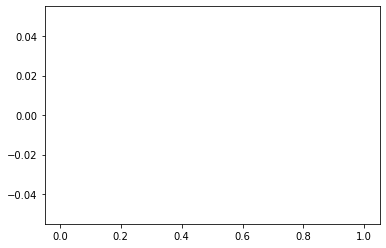

In [39]:
plt.hist(provamux[100:])

In [36]:
plt.hist(provasigma[100:])

NameError: ignored

In [ ]:
np.mean(provamu[100:])

In [ ]:
np.mean(provasigma[100:])

controlliamo il risultato plottando la posterior corretta